The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Image Augmentation

:label:`sec_image_augmentation`



We mentioned that large-scale datasets are prerequisites for the successful
application of deep neural networks in
:numref:`sec_alexnet`. Image augmentation technology expands the scale of training datasets
by making a series of random changes to the training images to produce similar,
but different, training examples. Another way to explain image augmentation is
that randomly changing training examples can reduce a model's dependence on
certain properties, thereby improving its capability for generalization. For
example, we can crop the images in different ways, so that the objects of
interest appear in different positions, reducing the model's dependence on the
position where objects appear. We can also adjust the brightness, color, and
other factors to reduce model's sensitivity to color. It can be said that image
augmentation technology contributed greatly to the success of AlexNet. In this
section we will discuss this technology, which is widely used in computer
vision.

First, import the packages or modules required for the experiment in this section.

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

## Common Image Augmentation Method

In this experiment, we will use an image with a shape of $400\times 500$ as an example.

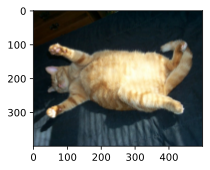

In [2]:
d2l.set_figsize((3.5, 2.5))
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, we next define the auxiliary function `apply`. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all results.

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Flipping and Cropping

Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation. Next, we use the `transforms` module to create the `RandomFlipLeftRight` instance, which introduces a 50% chance that the image is flipped left and right.

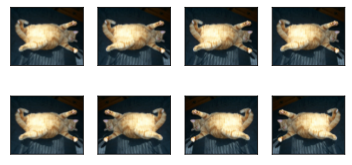

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

Flipping up and down is not as commonly used as flipping left and right. However, at least for this example image, flipping up and down does not hinder recognition. Next, we create a `RandomFlipTopBottom` instance for a 50% chance of flipping the image up and down.

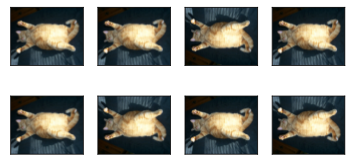

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

In the example image we used, the cat is in the middle of the image, but this
may not be the case for all images. In
:numref:`sec_pooling`,
we explained that the pooling layer can reduce the sensitivity of the
convolutional layer to the target location. In addition, we can make objects
appear at different positions in the image in different proportions by randomly
cropping the image. This can also reduce the sensitivity of the model to the
target position.

In the following code, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise stated, the random number between $a$ and $b$ in this section refers to a continuous value obtained by uniform sampling in the interval $[a, b]$.

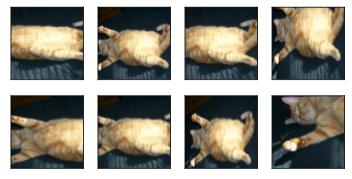

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Changing the Color

Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.

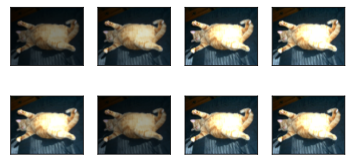

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

Similarly, we can randomly change the hue of the image.

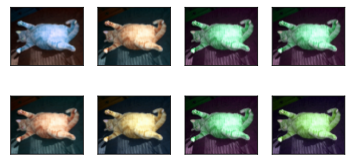

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

We can also create a `RandomColorJitter` instance and set how to randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time.

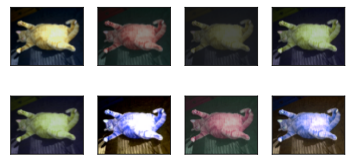

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Overlying Multiple Image Augmentation Methods

In practice, we will overlay multiple image augmentation methods. We can overlay the different image augmentation methods defined above and apply them to each image by using a `Compose` instance.

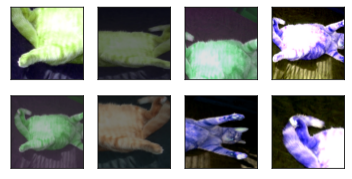

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## Using an Image Augmentation Training Model

Next, we will look at how to apply image augmentation in actual training. Here, we use the CIFAR-10 dataset, instead of the Fashion-MNIST dataset we have been using. This is because the position and size of the objects in the Fashion-MNIST dataset have been normalized, and the differences in color and size of the objects in CIFAR-10 dataset are more significant. The first 32 training images in the CIFAR-10 dataset are shown below.

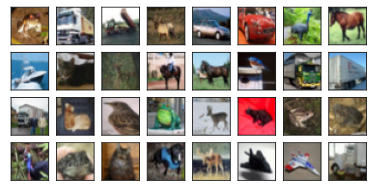

In [11]:
d2l.show_images(gluon.data.vision.CIFAR10(
    train=True)[0:32][0], 4, 8, scale=0.8);

In order to obtain a definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction. Here, we only use the simplest random left-right flipping method. In addition, we use a `ToTensor` instance to convert minibatch images into the format required by MXNet, i.e., 32-bit floating point numbers with the shape of (batch size, number of channels, height, width) and value range between 0 and 1.

In [12]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

Next, we define an auxiliary function to make it easier to read the image and
apply image augmentation. The `transform_first` function provided by Gluon's
dataset applies image augmentation to the first element of each training
example (image and label), i.e., the element at the top of the image. For
detailed description of `DataLoader`, refer to :numref:`sec_fashion_mnist`.

In [13]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

### Using a Multi-GPU Training Model

We train the ResNet-18 model described in :numref:`sec_resnet` on the
CIFAR-10 dataset. We will also apply the methods described in
:numref:`sec_multi_gpu_gluon` and use a multi-GPU training model.

Next, we define the training function to train and evaluate the model using multiple GPUs.

In [14]:
# Saved in the d2l package for later use
def train_batch_ch13(net, features, labels, loss, trainer, ctx_list,
                     split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    trainer.step(labels.shape[0])
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard)
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [15]:
# Saved in the d2l package for later use
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        metric[0] / metric[2], metric[1] / metric[3], test_acc))
    print('%.1f examples/sec on %s' % (
        metric[2] * num_epochs / timer.sum(), ctx_list))

Now, we can define the `train_with_data_aug` function to use image augmentation to train the model. This function obtains all available GPUs and uses Adam as the optimization algorithm for training. It then applies image augmentation to the training dataset, and finally calls the `train` function just defined to train and evaluate the model.

In [16]:
batch_size, ctx, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=ctx)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, ctx)

Now we train the model using image augmentation of random flipping left and right.

loss 0.177, train acc 0.939, test acc 0.845
4816.8 examples/sec on [gpu(0), gpu(1)]


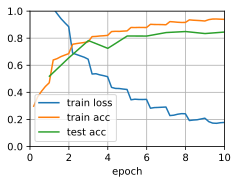

In [17]:
train_with_data_aug(train_augs, test_augs, net)

## Summary

* Image augmentation generates random images based on existing training data to cope with overfitting.
* In order to obtain a definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction.
* We can obtain classes related to image augmentation from Gluon's `transforms` module.

## Exercises

1. Train the model without using image augmentation: `train_with_data_aug(no_aug, no_aug)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
1. Add different image augmentation methods in model training based on the CIFAR-10 dataset. Observe the implementation results.
1. With reference to the MXNet documentation, what other image augmentation methods are provided in Gluon's `transforms` module?

## [Discussions](https://discuss.mxnet.io/t/2442)

![](../img/qr_image-augmentation.svg)